In [2]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=87ed1268a76a4dbf659792df5df19e74cb76f394a19368e545daf97fce113ea1
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as fin
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def setup():
    sp500 = fin.Ticker('^GSPC')
    tickers = [
        fin.Ticker('MSFT'),
        fin.Ticker('AAPL'),
        fin.Ticker('NVDA'),
        fin.Ticker('AMZN'),
        fin.Ticker('META'),
        fin.Ticker('GOOGL'),
        fin.Ticker('GOOG'),
        fin.Ticker('BRK-B'),
        fin.Ticker('LLY'),
        fin.Ticker('AVGO'),
        fin.Ticker('JPM'),
        fin.Ticker('TSLA'),
        fin.Ticker('UNH'),
        fin.Ticker('XOM'),
        fin.Ticker('V'),
        fin.Ticker('PG'),
        fin.Ticker('JNJ'),
        fin.Ticker('MA'),
        fin.Ticker('COST'),
        fin.Ticker('HD'),
        fin.Ticker('ABBV'),
        fin.Ticker('WMT'),
        fin.Ticker('MRK'),
        fin.Ticker('KO'),
        fin.Ticker('NFLX'),
        fin.Ticker('BAC'),
        fin.Ticker('CVX'),
        fin.Ticker('PEP'),
        fin.Ticker('CRM'),
        fin.Ticker('ADBE'),
        fin.Ticker('TMO'),
        fin.Ticker('LIN'),
        fin.Ticker('AMD'),
        fin.Ticker('ORCL'),
        fin.Ticker('ACN'),
        fin.Ticker('MCD'),
        fin.Ticker('ABT'),
        fin.Ticker('CSCO'),
        fin.Ticker('WFC'),
        fin.Ticker('PM'),
        fin.Ticker('QCOM'),
        fin.Ticker('IBM'),
        fin.Ticker('DIS'),
        fin.Ticker('GS'),
        fin.Ticker('UBER'),
        fin.Ticker('BLK'),
        fin.Ticker('MS'),
        fin.Ticker('C')
    ]

    sp500 = sp500.history(period="max")

    sp500['Up'] = (sp500['Close'].shift(-1) > sp500['Close']).astype(int)

    sp500.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
    sp500['RSI'] = ta.rsi(sp500['Close'], length=14)
    macd = ta.macd(sp500['Close'], fast=12, slow=26, signal=9)
    sp500['MACD'] = macd['MACD_12_26_9']
    sp500['MACD_signal'] = macd['MACDs_12_26_9']
    bbands = ta.bbands(sp500['Close'], length=20, std=2)
    sp500['upper_band'] = bbands['BBU_20_2.0']
    sp500['middle_band'] = bbands['BBM_20_2.0']
    sp500['lower_band'] = bbands['BBL_20_2.0']
    stoch = ta.stoch(sp500['High'], sp500['Low'], sp500['Close'], k=14, d=3, smooth_k=3)
    sp500['slowk'] = stoch['STOCHk_14_3_3']
    sp500['slowd'] = stoch['STOCHd_14_3_3']
    sp500['OBV'] = ta.obv(sp500['Close'], sp500['Volume'])
    sp500=sp500.dropna()

    sp500 = sp500.loc["1990-01-01":].copy()
    predictors = ["RSI","MACD"]

    horizons = [2, 5, 20, 60, 250, 1250]

    for horizon in horizons:
        rolling_avg = sp500.rolling(horizon).mean()

        ratio_col = "Close Ratio: " + str(horizon)
        sp500[ratio_col] = sp500["Close"] / rolling_avg["Close"]

        trend_col = "Trend: " + str(horizon)
        sp500[trend_col] = sp500.shift(1).rolling(horizon).sum()['Up']

        predictors.extend([ratio_col, trend_col])




    for i in range(len(tickers)):
        symbol = tickers[i].info['symbol']
        ticker = tickers[i].history(period="max")
        ticker = ticker.loc["1990-01-01":].copy()

        ticker.drop(columns=['Dividends', 'Stock Splits', 'High', 'Low'], inplace=True)


        close_col = symbol + ' Close'
        open_col = symbol + ' Open'
        vol_col = symbol + ' Vol'
        missing_col = symbol + ' Missing'

        predictors.extend([close_col, open_col, vol_col, missing_col])

        ticker.rename(columns={'Close': close_col, 'Open': open_col, 'Volume': vol_col}, inplace=True)

        sp500 = pd.merge(sp500, ticker, on="Date", how="left").copy()

        sp500[missing_col] = sp500[close_col].isna().astype(int)
        sp500.fillna(-1, inplace=True)


    model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)


    return sp500, predictors, model

In [11]:
sp, predictors, model = setup()

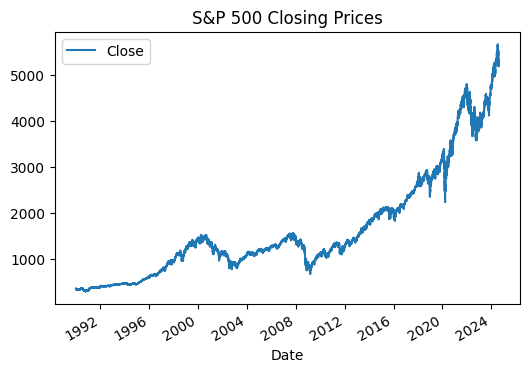

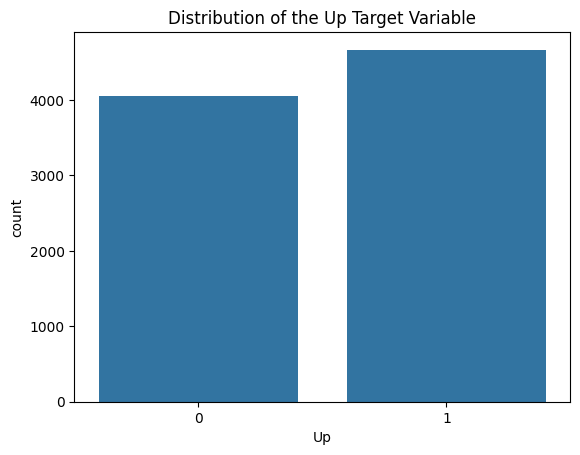

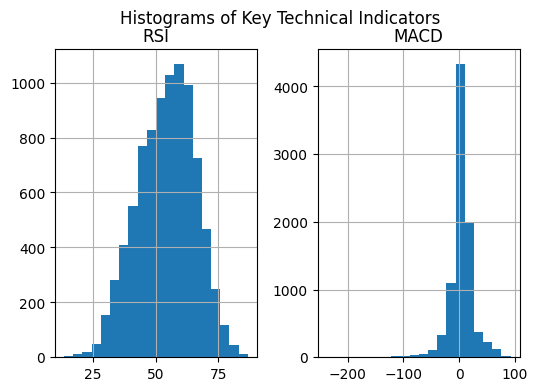

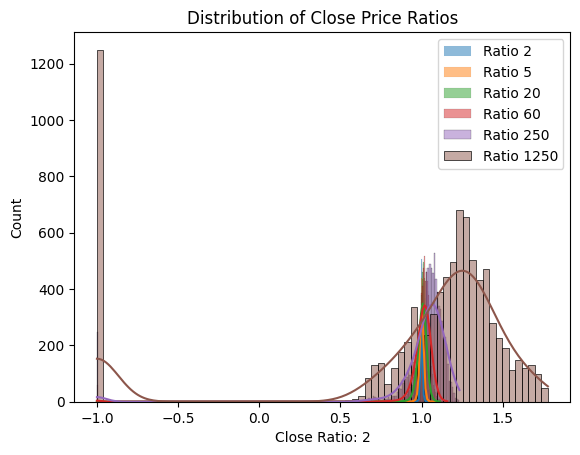

In [17]:
sp.plot.line(y="Close",use_index=True, figsize=(6, 4))
plt.title('S&P 500 Closing Prices')
plt.show()

sns.countplot(x='Up', data=sp)
plt.title('Distribution of the Up Target Variable')
plt.show()

sp[['RSI', 'MACD',]].hist(bins=20, figsize=(6, 4))
plt.suptitle('Histograms of Key Technical Indicators')
plt.show()

for horizon in [2, 5, 20, 60, 250, 1250]:
    ratio_col = "Close Ratio: " + str(horizon)
    sns.histplot(sp[ratio_col], kde=True, label=f"Ratio {horizon}")
plt.title('Distribution of Close Price Ratios')
plt.legend()
plt.show()

In [ ]:
def predict(train,test,predictors,model):
  model.fit(train[predictors],train["Up"])
  guess=model.predict_proba(test[predictors])[:,1]
  guess[guess>=.6]=1
  guess[guess<.6]=0
  guess=pd.Series(guess,index=test.index,name="Predictions")
  combined=pd.concat([test["Up"],guess],axis=1)
  return combined

In [ ]:
def backtest(data,model,predictors,start=2500,step=250):
  allPredictions=[]
  for i in range(start,data.shape[0],step):
    train=data.iloc[0:i].copy()
    test=data.iloc[i:(i+step)].copy()
    predictions=predict(train,test,predictors,model)
    allPredictions.append(predictions)
  return pd.concat(allPredictions)

In [15]:
preds = backtest(sp, model, predictors,start=2500,step=250)

In [16]:
precision_score(preds["Up"], preds["Predictions"])

0.6593406593406593